From what we've built so far, there is plenty of room for improvement.

We could go down the route of trying different configurations, adding layers, changing the learning rate, adjusting neurons per layer etc but that will be very time consuiming. What about **transfer learning?** We're yet to try that out. It
is the concept of taking patterns (also called weights) that another model has learned and applying it to our model.

The main benefits of using this approach are:
1. Can leverage existing neural network arcitectures proven to work on problems similar to our own
2. Can leverage a working neural network architecture that has already learnt patterns on similar data to our own

Doing this leads to great results with less data.

In [26]:
#Are we using a GPU?

!nvidia-smi

Fri Jun 17 11:03:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    31W /  70W |    390MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Transfer Learning with TF Hub: Getting great results with 10% of the data

Let's take 10% of the training data from the 10_food_classes dataset and use it to train a food image classifier on

## Downloading and Becoming One with the Data

In [27]:
# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-06-17 11:03:12--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.99.128, 173.194.202.128, 173.194.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.99.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   266MB/s    in 0.6s    

2022-06-17 11:03:13 (266 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [28]:
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} dieectories and {len(filenames)} images in '{dirpath}'.")


There are 2 dieectories and 0 images in '10_food_classes_10_percent'.
There are 10 dieectories and 0 images in '10_food_classes_10_percent/train'.
There are 0 dieectories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 dieectories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 dieectories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 dieectories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 dieectories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 dieectories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 dieectories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 dieectories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 dieectories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 dieectories and 75 images in '10_food_classes_10_percent

We're training on 10% of the original 750 images but evaluating our model on the same amount of test data

## Creating data loaders (preparing the data)

Now we'll use `ImageDataGenerator` along with `flow_from_directory` method to load in our images

In [29]:
#setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size= BATCH_SIZE,
                                                          class_mode = "categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory (test_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size= BATCH_SIZE,
                                               class_mode = "categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting Up Callbacks (Things to do whilst our model trains)

some  **callbacks** include:
* Experiment tracking with TensoBoard - log performance of multiple models then view and compare these in a visual way
* Model checkpointing - Save model as i trains so you can stop training if need be and come back to continue where you left off
* Early stopping - Leabe model to train an arbitary amount of time an dhave it stop automatically when it ceases to improve

We'll start off bydoing a TensorBoard example since we're likely to run multiple experiments



In [30]:
# Create tensorboard callback (functionized because we need to create a new one for each model)

import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir =log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In our case, our function saves a model's performance logs to a directory named [dir_name]/[experiment_name]/[current_timestamp]

## Creating models using TF Hub

Previously we've used TF to create our own models layer by layer from scratch.

Now, we're going to do a similar process, except the majority of our model's layers are going to come from TF Hub. We'll look at two models specifically:
1. ResNetV2 - SOTA vision model from 2016
2. EfficientNet - SOTA vision architecture from 2019

Since we're working with images, our targets are the models which perform best with ImageNet.

You'll probably find not all of the model architectures listed on paperswithcode appear on TensorFlow Hub. And this is okay, we can still use what's available.

To find our models, let's narrow down our search using the Architecture tab.

1. Select the Architecture tab on TensorFlow Hub and you'll see a dropdown menu of architecture names appear.


>> The rule of thumb here is generally, names with larger numbers means better performing models. For example, EfficientNetB4 performs better than EfficientNetB0.

>> However, the tradeoff with larger numbers can mean they take longer to compute.

2. Select EfficientNetB0 

3. Clicking the one titled "efficientnet/b0/feature-vector" brings us to a page with a button that says "Copy URL". That URL is what we can use to harness the power of EfficientNetB0.
> Copying the URL should give you something like this: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1
> 
🤔Question: I thought we were doing image classification, why do we choose feature vector and not classification?

>Great observation. This is where the differnet types of transfer learning come into play, as is, feature extraction and fine-tuning.




1. **"As is" transfer learning** is when you take a pretrained model as it is and apply it to your task without any changes.

>* For example, many computer vision models are pretrained on the ImageNet dataset which contains 1000 different classes of images. This means passing a single image to this model will produce 1000 different prediction probability values (1 for each class).

>>* This is helpful if you have 1000 classes of image you'd like to classify and they're all the same as the ImageNet classes, however, it's not helpful if you want to classify only a small subset of classes (such as 10 different kinds of food). Model's with "/classification" in their name on TensorFlow Hub provide this kind of functionality.

2. **Feature extraction transfer learning** is when you take the underlying patterns (also called weights) a pretrained model has learned and adjust its outputs to be more suited to your problem.

>* For example, say the pretrained model you were using had 236 different layers (EfficientNetB0 has 236 layers), but the top layer outputs 1000 classes because it was pretrained on ImageNet. To adjust this to your own problem, you might remove the original activation layer and replace it with your own but with the right number of output classes. The important part here is that only the top few layers become trainable, the rest remain frozen.

>>* This way all the underlying patterns remain in the rest of the layers and you can utilise them for your own problem. This kind of transfer learning is very helpful when your data is similar to the data a model has been pretrained on.

3. **Fine-tuning transfer learning** is when you take the underlying patterns (also called weights) of a pretrained model and adjust (fine-tune) them to your own problem.

>* This usually means training some, many or all of the layers in the pretrained model. This is useful when you've got a large dataset (e.g. 100+ images per class) where your data is slightly different to the data the original model was trained on.

A common workflow is to "freeze" all of the learned patterns in the bottom layers of a pretrained model so they're untrainable. And then train the top 2-3 layers of so the pretrained model can adjust its outputs to your custom data (feature extraction).

After you've trained the top 2-3 layers, you can then gradually "unfreeze" more and more layers and run the training process on your own data to further fine-tune the pretrained model.

🤔 **Question:** Why train only the top 2-3 layers in feature extraction?

The lower a layer is in a computer vision model as in, the closer it is to the input layer, the larger the features it learn. For example, a bottom layer in a computer vision model to identify images of cats or dogs might learn the outline of legs, where as, layers closer to the output might learn the shape of teeth. Often, you'll want the larger features (learned patterns are also called features) to remain, since these are similar for both animals, where as, the differences remain in the more fine-grained features.

In [31]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [32]:
# resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EffiecientNetB0 feature vector (version 1) - note version 2  is also available and can be tried out as well
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

Since we're going to be comparing two models, to ourselves code, we'll write a function `**create_model**` that will take a model's TF Hub URL, instantiate a Keras Sequential model with the appropriate number of output layers and return the model.

In [33]:
def create_model(model_url, num_classes=10):

  """ Takes a TF Hub URL and creates a Keras Sequential model with it

  Args:
    model_url (str): A TF Hub feature extraction URL
    num_classes (int): Number of output neurons in output layer should be equal to number of classes, default 10.

  Returns: 
    An uncompiled Keras Sequential model with model_url as feature extractor layer and Dense output layer with num_classes outputs
  """

  # Download the pretrained model and save it as a keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                          trainable = False,
                                          name= 'feature_extraction_layer',
                                          input_shape = IMAGE_SHAPE+(3,))

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, #use feature extractor layer as base
    layers.Dense(num_classes, activation = 'softmax', name = 'output_layer') #create an output layer
  ])

  return model
                                         

We'll now use this function to create our first model using the ResNetV250 as the feature extraction layer and then, onc the model is instantiated we'll compile as usual

In [34]:
# Create the model
resnet_model = create_model(resnet_url, num_classes = train_data_10_percent.num_classes)

#compile
resnet_model.compile(loss = 'categorical_crossentropy',
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ['accuracy'])

We'll now fit the model and train for 5 epochs, we'll also introduce the `callbacks` parameter and pass it through the `create_tensorboard_callback` function that we created earlier. 



In [36]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs = 5,
                                  steps_per_epoch = len(train_data_10_percent),
                                  validation_data = test_data,
                                  validation_steps = len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks = [create_tensorboard_callback(dir_name = "tensorflow_hub", #save experiment logs here
                                                                           experiment_name = "resnet50V2")]) #name of log files
                                

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20220617-110939
Epoch 1/5
24/24 [==============================] - 40s 1s/step - loss: 1.9675 - accuracy: 0.3560 - val_loss: 1.1801 - val_accuracy: 0.6508
Epoch 2/5
24/24 [==============================] - 16s 701ms/step - loss: 0.9156 - accuracy: 0.7373 - val_loss: 0.8341 - val_accuracy: 0.7408
Epoch 3/5
24/24 [==============================] - 16s 688ms/step - loss: 0.6159 - accuracy: 0.8320 - val_loss: 0.7386 - val_accuracy: 0.7684
Epoch 4/5
24/24 [==============================] - 16s 698ms/step - loss: 0.4809 - accuracy: 0.8760 - val_loss: 0.6906 - val_accuracy: 0.7768
Epoch 5/5
24/24 [==============================] - 17s 720ms/step - loss: 0.3769 - accuracy: 0.9173 - val_loss: 0.6610 - val_accuracy: 0.7924


Wow! With only 5 epochs we've managed to reach 92% accuracy on training data and 80% accuracy on testing data, far better than any of the models we've built so far and **with only 10 images!** Let's plot our results.

In [37]:
import matplotlib.pyplot as plt
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();


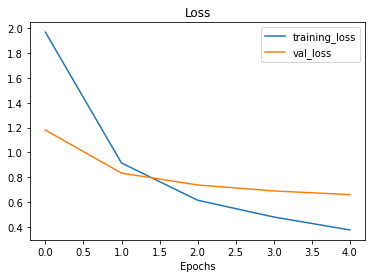

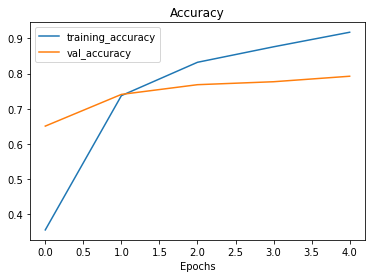

In [38]:
plot_loss_curves(resnet_history)

In [39]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


This shows the power of tensorflow_hub, the feature extraction layer has 23 564 800 parameters which are prelearned patterns the model has already learned on the ImageNet dataset. Since trainable=False, these patterns remain frozen during training.

This means during training the model updates the 20 490 parameters in the output layer to suit our dataset.

Let's try the EfficientNetB0 model now.

In [40]:
# Create the model
efficientnet_model = create_model(efficientnet_url, num_classes = train_data_10_percent.num_classes)

#compile
efficientnet_model.compile(loss = 'categorical_crossentropy',
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ['accuracy'])
# Fit the model
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                  epochs = 5,
                                  steps_per_epoch = len(train_data_10_percent),
                                  validation_data = test_data,
                                  validation_steps = len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks = [create_tensorboard_callback(dir_name = "tensorflow_hub", #save experiment logs here
                                                                           experiment_name = "efficientnetB0")]) #name of log files


Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20220617-114733
Epoch 1/5
24/24 [==============================] - 26s 740ms/step - loss: 1.8298 - accuracy: 0.4453 - val_loss: 1.2770 - val_accuracy: 0.7388
Epoch 2/5
24/24 [==============================] - 16s 672ms/step - loss: 1.0454 - accuracy: 0.7747 - val_loss: 0.8644 - val_accuracy: 0.8184
Epoch 3/5
24/24 [==============================] - 17s 735ms/step - loss: 0.7461 - accuracy: 0.8427 - val_loss: 0.6967 - val_accuracy: 0.8380
Epoch 4/5
24/24 [==============================] - 16s 671ms/step - loss: 0.6024 - accuracy: 0.8667 - val_loss: 0.6103 - val_accuracy: 0.8492
Epoch 5/5
24/24 [==============================] - 16s 669ms/step - loss: 0.5091 - accuracy: 0.8947 - val_loss: 0.5573 - val_accuracy: 0.8588


EfficientNet performs even better than ResNet using only 10% of the training data!

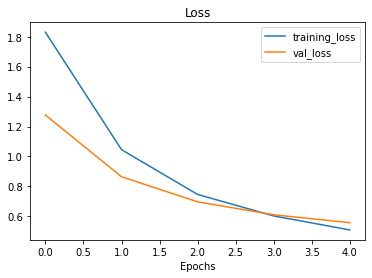

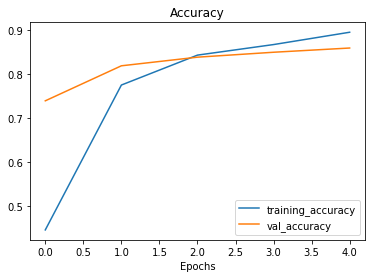

In [43]:
plot_loss_curves(efficientnet_history)

From the llooks of it, training our data for longer would produce even better results, let's confirm..

In [45]:
# Create the model
efficientnet_model = create_model(efficientnet_url, num_classes = train_data_10_percent.num_classes)

#compile
efficientnet_model.compile(loss = 'categorical_crossentropy',
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ['accuracy'])
# Fit the model
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                  epochs = 10,
                                  steps_per_epoch = len(train_data_10_percent),
                                  validation_data = test_data,
                                  validation_steps = len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks = [create_tensorboard_callback(dir_name = "tensorflow_hub", #save experiment logs here
                                                                           experiment_name = "efficientnetB0")]) #name of log files

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20220617-115205
Epoch 1/10
24/24 [==============================] - 25s 710ms/step - loss: 1.8455 - accuracy: 0.4493 - val_loss: 1.3146 - val_accuracy: 0.7284
Epoch 2/10
24/24 [==============================] - 16s 667ms/step - loss: 1.0551 - accuracy: 0.7933 - val_loss: 0.8665 - val_accuracy: 0.8200
Epoch 3/10
24/24 [==============================] - 16s 690ms/step - loss: 0.7448 - accuracy: 0.8453 - val_loss: 0.6951 - val_accuracy: 0.8460
Epoch 4/10
24/24 [==============================] - 16s 681ms/step - loss: 0.5980 - accuracy: 0.8827 - val_loss: 0.6055 - val_accuracy: 0.8560
Epoch 5/10
24/24 [==============================] - 15s 661ms/step - loss: 0.5072 - accuracy: 0.8960 - val_loss: 0.5577 - val_accuracy: 0.8600
Epoch 6/10
24/24 [==============================] - 17s 745ms/step - loss: 0.4402 - accuracy: 0.9173 - val_loss: 0.5194 - val_accuracy: 0.8664
Epoch 7/10
24/24 [==============================] - 17s 743ms/s

In [46]:
efficientnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


Notice how EfficientNet has over four times less parameters than the ResNet extraction layer. 

## Comparing Models Using TensorBoard

It's easy enough to compare two models against eachother by scrolling up and reading their accuracies but what if we had more than two models?

That's where TensorBoard and our TensorBoard callback that we've set up comes in. All of our model's training logs have been saved automatically. To visualize them, we can upload the results to TensorBoard.dev

### Uploading experiments to TensorBoard

To upload a series of TensorFlow logs to TensorBoard, we can use the following command:

Upload TensorBoard dev records

`**!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \ 
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot **`

Where:

 - `logdir` is the target upload directory
 - `name` is the name of the experiment
 - `description` is a brief description of the experiment
 - `one_shot` exits the TensorBoard uploader once uploading is finished

Running the tensorboard dev upload command will first ask you to authorize the upload to TensorBoard.dev. After you've authorized the upload, your log files will be uploaded

In [48]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=LCIO90HwnEQNWEdY4YSVtfMRRJAtAo&prompt=consent&access_type=off

### List Experiments you've saved to TensorBoard

In [49]:
# Check out experiments
!tensorboard dev list

https://tensorboard.dev/experiment/CPZPd4MhQsm4I4yrnZFvtQ/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction models architectures using 10% of training images
	Id                   CPZPd4MhQsm4I4yrnZFvtQ
	Created              2022-06-17 12:05:37 (1 minute ago)
	Updated              2022-06-17 12:05:49 (1 minute ago)
	Runs                 6
	Tags                 5
	Scalars              120
	Tensor bytes         0
	Binary object bytes  9999304
Total: 1 experiment(s)


In [50]:
#To delete an experiment type this:
#!tensorboard dev delete --experiment_i[INSERT_EXPERIMENT_ID]